# Customizing contact map plots

The main plotting methods use matplotlib. If you're already familiar with matplotlib, you'll have a good background already, and if not, what you learn about Contact Map Explorer will transfer to other projects.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")

In [3]:
from contact_map import ContactFrequency
traj_contacts = ContactFrequency(traj)
frame_contacts = ContactFrequency(traj[0])
diff = traj_contacts - frame_contacts

## Putting multiple plots in one figure

You may want to plot multiple maps on one figure. This can easily be done by using the `plot_axes` method, which acts just like `plot` except that it requires that you give it a Matplotlib `Axes` object to plot into.

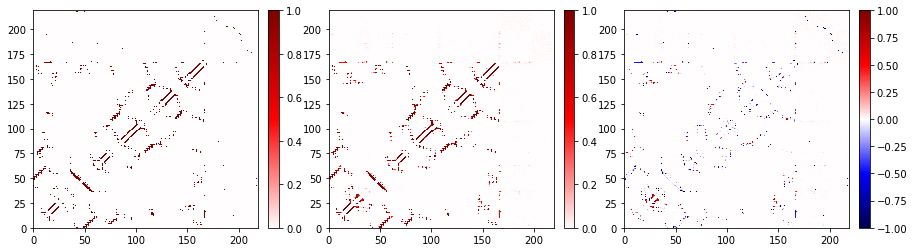

In [5]:
# Make a subplot with 1 row but three columns and a bigger figsize
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Flatten the axis to a list
axs = axs.flatten()

# Make a list of the contact objects we want to plot in this case: frame, trajectory, 
# difference
contacts = [frame_contacts, traj_contacts, diff]

# Now loop and make the plot
for ax, contact in zip(axs, contacts):
    contact.residue_contacts.plot_axes(ax=ax)

## Changing the color map

You can use any Matplotlib color map, see the [Matplotlib documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for details. In general, the color schemes that you are likely to use with Contact Map Explorer are either "diverging" or "sequential." Diverging color maps are useful when looking at contact differences. The default color map is `seismic`, which is a diverging contact map.

Contact Map Explorer has some extra tricks to make it so that the same color map works for either contact frequencies or contact differences: if given a diverging map, and if there are no negative values in the data, Contact Map Explorer will only use the upper half of the contact map.

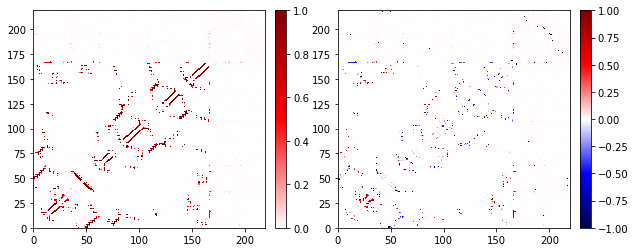

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
traj_contacts.residue_contacts.plot_axes(ax=axs[0]);
diff.residue_contacts.plot_axes(ax=axs[1]);

Note that you're using the same color map in both, but when there's no negative data, we only use the upper half. We can do the same with any diverging color map; next we'll use the purple-green diverging map `PRGn`.

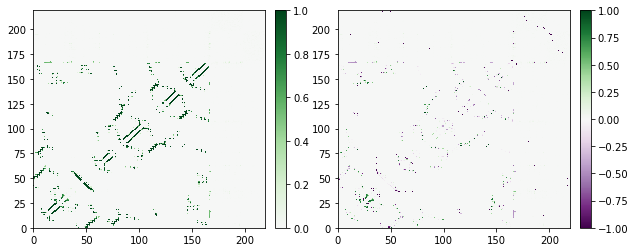

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
traj_contacts.residue_contacts.plot_axes(ax=axs[0], cmap='PRGn');
diff.residue_contacts.plot_axes(ax=axs[1], cmap='PRGn');

If you want to use a sequential map, use `vmin=0`.

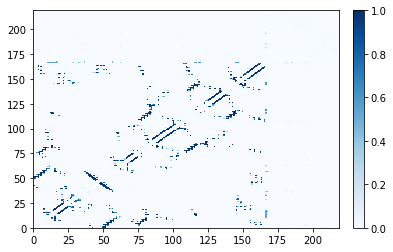

In [8]:
traj_contacts.residue_contacts.plot(cmap="Blues", vmin=0);

## Common matplotlib customizations

* changing axis ticks to match your actual numbering

In [9]:
# TODO

## Performance when plotting

While `residue_contact.plot()` is obviously a very easy way to make a plot, you can always convert the contact data to another format and then plot using other tools. For more on various methods to 

Sometimes different plotting methods will be faster than the built-in version. For example, when the contact matrix is relatively dense, as with the example with a larger cutoff, it can be faster to go by way of exporting to pandas and plotting the DataFrame using `matplotlib.pyplot.pcolor`.

In [20]:
%%time
large_cutoff = ContactFrequency(trajectory=traj[::10], cutoff=1.5)

CPU times: user 17.8 s, sys: 190 ms, total: 18 s
Wall time: 18.1 s


CPU times: user 16.2 s, sys: 211 ms, total: 16.4 s
Wall time: 16.8 s


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7bd7a64a8>)

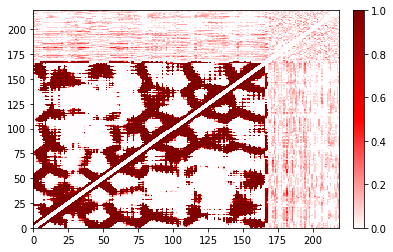

In [21]:
%%time
large_cutoff.residue_contacts.plot();

CPU times: user 633 ms, sys: 15.2 ms, total: 648 ms
Wall time: 703 ms


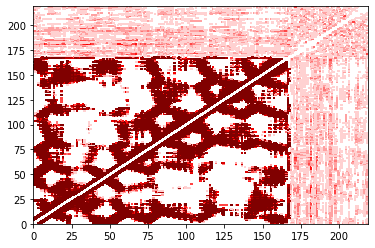

In [22]:
%%time
import matplotlib
cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

plot = plt.pcolor(large_cutoff.residue_contacts.df, cmap='seismic', vmin=-1,
                  vmax=1)
plot.cmap.set_under(cmap(norm(0)));

You'll notice that these may not be pixel-perfect copies. This is because the number of pixels doesn't evenly divide into the number of residues. You can improve this by increasing the resolution (`dpi` in matplotlib) or the figure size. However, in both versions you can see the overall structure quite clearly. In addition, the color bar is only shown in the built-in version.